In [159]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from itertools import cycle
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [160]:
# Load Dataset
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

In [161]:
# EN Dataset
# Read CSV Files
en_dev = pd.read_csv('mswc_microset/mswc_microset/en/en_dev.csv')
en_splits = pd.read_csv('mswc_microset/mswc_microset/en/en_splits.csv')
en_test = pd.read_csv('mswc_microset/mswc_microset/en/en_test.csv')
en_train = pd.read_csv('mswc_microset/mswc_microset/en/en_train.csv')

# Create EN Dataframe
df = pd.concat([en_dev, en_splits, en_test, en_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

In [162]:
df

,LINK,WORD,VALID,SPEAKER,GENDER
0,backward/common_voice_en_18751858.opus,backward,True,90a2539a7010c22f8d1379231f2b3e5829a0e645060d823d4421f270950a0c5be5a4c17dec76306c383f14de9ce8360149cc679dd60a951807e7650edf6d2bd3,MALE
1,backward/common_voice_en_19346834.opus,backward,True,da4bd5bc7a79e8f1140a50f2abecb7311ca2aa154f7fc5787b4b4956d5fb6bf3e9cef15b501cf9ba7c4598a014627aafe5f0a372eca6b867ddc8493ba5dae292,MALE
2,backward/common_voice_en_19453264.opus,backward,True,ae8b4178829ab4b9b395453535a478fd0e130fa7755bb04d396fee901531ea1a9a9bf511da0a1a34bca1f71e7cdd1fdf8db5c3bf87d636a90978c676b671d61d,FEMALE
3,bed/common_voice_en_100630.opus,bed,True,c032b998824777d2f1c94c3e7d73ebe9737feffbd911262eb0e669eb484dfcca3fc51ef1d6965bd652f013a89f1d0b9fb6aed4c62210c0d6da3d2203b4b2d1c9,NAN
4,bed/common_voice_en_101920.opus,bed,True,2b82891368bae471e0f963fef061a55ba179bf39dbbba38d8b7aa335cc9be4a4b57a3163107f974a44d7c107dd58286a567931de2fa441d276be45958ff40124,NAN
...,...,...,...,...,...
192193,zero/common_voice_en_78240.opus,zero,True,8d358cd486307f75894ac21199088bd5b257925d8546edd6792649cb63917c4fa5d7f8f3d11407ac796f944f6c3288b56ddb5c55bd7128af64ee64e6bea1fc17,NAN
192194,zero/common_voice_en_78318.opus,zero,True,8d358cd486307f75894ac21199088bd5b257925d8546edd6792649cb63917c4fa5d7f8f3d11407ac796f944f6c3288b56ddb5c55bd7128af64ee64e6bea1fc17,NAN
192195,zero/common_voice_en_82773.opus,zero,True,15e4d9ab7354059d46510972084acf34850b285ce2c6594f2aa6287c57d29efd02aaae94a4abc0e184462c176e7cdb7c2bfc393060b25fccdd94f90c7cdd985b,NAN
192196,zero/common_voice_en_87145.opus,zero,True,aae8d8ca717f852a652c7f0c18eda0af3fb66083559897a44933bdf097da5e8ebb9546febec14ed349c17ef96b2a8652e143dc65cfa875da1ecb727091330ddd,NAN


In [163]:
balanced_samples = []
unique_words = df['WORD'].unique()

for word in unique_words:
    word_df = df[df['WORD'] == word]

    # Split by gender
    male_df = word_df[word_df['GENDER'] == 'MALE']
    female_df = word_df[word_df['GENDER'] == 'FEMALE']

    if len(male_df) >= 150 and len(female_df) >= 150:
        sampled_male = male_df.sample(n=150, random_state=42)
        sampled_female = female_df.sample(n=150, random_state=42)
        balanced_samples.append(pd.concat([sampled_male, sampled_female]))
    else:
        print(f"Skipping '{word}': not enough data (Male={len(male_df)}, Female={len(female_df)})")

# Only concatenate if we have valid samples
if balanced_samples:
    final_df = pd.concat(balanced_samples).reset_index(drop=True)
    print(f"Final dataset size: {len(final_df)}")
else:
    print("No words had enough gender-balanced data.")

Skipping 'backward': not enough data (Male=30, Female=14)
Skipping 'marvin': not enough data (Male=42, Female=12)
Skipping 'sheila': not enough data (Male=14, Female=6)
Skipping 'visual': not enough data (Male=288, Female=64)
Skipping 'wow': not enough data (Male=230, Female=50)
Skipping 'zero': not enough data (Male=362, Female=88)
Final dataset size: 7500


In [164]:
processed_data = {
    'LINK': [],
    'WORD': [],
    'VALID': [],
    'SPEAKER': [],
    'GENDER': [],
    'MFCC': []
}

In [165]:
def process_audio(file_path):
    y, sr = librosa.load(file_path)
    y_trimmed, _ = librosa.effects.trim(y, top_db=40)
    mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=20, n_mels=128)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

In [166]:
for index, row in final_df.iterrows():
    file_path = row['LINK']
    try:
        mfcc_mean = process_audio(f'mswc_microset/mswc_microset/en/clips/{file_path}')
        # Store all the data
        processed_data['LINK'].append(row['LINK'])
        processed_data['WORD'].append(row['WORD'])
        processed_data['VALID'].append(row['VALID'])
        processed_data['SPEAKER'].append(row['SPEAKER'])
        processed_data['GENDER'].append(row['GENDER'])
        processed_data['MFCC'].append(mfcc_mean)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        continue

processed_df = pd.DataFrame(processed_data)

X = np.array(processed_df['MFCC'].tolist())
y = processed_df['WORD'].values
genders = processed_df['GENDER'].values

In [167]:
processed_df

,LINK,WORD,VALID,SPEAKER,GENDER,MFCC
0,bed/common_voice_en_17296742.opus,bed,True,370f6a3162b62f534892c6a182bfa2bc88fe26b3517cbcc1ca0a5c7bb2c0fc71346437d0367bf03018930d3a4a0aee139f716225c16aec6dcfe29f335ee3a8b4,MALE,"[-298.27563, 160.0353, -34.278454, 57.84715, 6.0212235, -12.800717, -3.2786672, -17.866194, -26.960587, 3.840583, 14.8963995, -19.52974, 2.73364, 0.1692211, -11.869931, -4.82601, -13.976482, -3.5871935, 7.078076, -6.3319283]"
1,bed/common_voice_en_578084.opus,bed,True,f3cdfa49be1c7941106c47dd33a80f7528f85d3ad431c3411787193a0c1a62745bb0e028899a014c5e1ac5529f1e4cde4768d8e7ba41ded7ea11ad3c86f9e01d,MALE,"[-523.3271, 48.73351, -13.282576, 46.38868, 7.0378785, -4.1425753, -16.73373, -16.102776, 9.905575, -5.2399096, 1.2013004, 8.145457, -6.834135, 12.074912, 8.797858, 5.2537866, -4.2030973, 14.514718, -12.287848, 9.458643]"
2,bed/common_voice_en_204343.opus,bed,True,15f5d75682514c297f6fc805bd59775097677db505c0ca74e3519a4cb5cdc8d2f46c833e68a23482b119918d5b6ef64fb3407432e2b16526f18d072dc59440ac,MALE,"[-373.56592, 133.99358, -67.2484, 4.307431, 0.010830487, -12.144374, -44.0883, -11.836358, -35.986538, 10.729454, -3.4777982, -13.792017, -1.7622501, -0.94304675, 6.2132077, 1.9587243, -12.35568, -11.001837, 1.940014, -1.5592381]"
3,bed/common_voice_en_17912234.opus,bed,True,c1097f33f82e4d827373a4b820ff78dca39c3c9b0490a435e1ea2631d1bcebe626abde92bd3e64ef097da0030a811581fc6a63f368fd6e23cdde7aeda9375dbb,MALE,"[-428.70758, 130.4566, 37.89545, 19.842997, 22.280422, 1.1393518, 2.8059094, -14.422349, -5.7184176, -8.947321, 2.771327, -0.649433, -2.200604, -2.6875224, -2.9793496, 7.030711, -0.5882896, 2.3587418, -9.27313, -1.8770576]"
4,bed/common_voice_en_17246522.opus,bed,True,d0b62ac1e57e267f16088ee614cdaf09a9826c3b704ce2f79746ef16e248c19f9ff54ab124c25647def1f4414dc2a510eb8b6cfd3a41ae6681571b91b2a6f9df,MALE,"[-474.04565, 145.15178, -12.111359, 27.952778, 36.057915, -32.74521, -16.41906, -29.73576, 1.1673619, 6.7289486, -6.776602, -5.5557957, 10.891711, -2.2193842, 9.342717, 4.782259, -13.369452, 8.405525, -5.9878106, -13.776724]"
...,...,...,...,...,...,...
7495,yes/common_voice_en_18664568.opus,yes,True,4dcbcad4784e1ed4ac8b4ff5041d6563a4715c625ebbbc049b4ad77c30bf8cb977caf1642d910741d6ec38dcec1b7595f3d78b0e0e6910180e33e8df9354fc9c,FEMALE,"[-403.79004, 33.25622, 65.23154, -6.850681, 15.00597, -26.178165, -13.502745, -2.2534585, -10.188805, -5.5569873, -13.4188385, 1.52323, -4.1866074, -6.5357423, -0.03251482, -4.000064, -7.3328238, 1.983664, -13.089602, -2.5639265]"
7496,yes/common_voice_en_17432377.opus,yes,True,9bf2140f31463cde58df1859c772e2668a6a81f3c36a88910822de072cb0d64b379179a7bcec934c0422b4ba28633986202fe7f1b068f6016b445ffab807dff6,FEMALE,"[-362.57944, 91.97308, -8.821402, 43.207615, -2.9377723, 7.4900365, -25.950752, 23.55709, -4.045715, -6.809921, -8.098303, -12.652453, -8.786785, -15.130711, 1.8298187, -11.370367, -4.447728, -7.8492084, -6.311972, 2.0516117]"
7497,yes/common_voice_en_18668336.opus,yes,True,f2909ec9143e4ff4792b0ccb2e109da938c1c5bfc91641165b0fd32f6caf67ad234318233affcaa4117a36212440eae89dbf06c75e2cb9d4a19ddec3663044ac,FEMALE,"[-300.4454, 29.935196, -89.960205, 2.0911129, -60.519, 13.24347, -29.433023, -4.067509, 1.14123, 8.963519, 3.1709402, -8.7562, 8.7374735, 2.601797, 9.434796, -1.8444386, -0.3961109, -11.594272, -3.8851871, -7.210673]"
7498,yes/common_voice_en_17920002.opus,yes,True,1bc6f6cc91f5d6db1ef0ed24173ff21d9141196f68cb2d5302c251a0eb4d4e764662a40efd6ecf9cddc7a032a823129e9b880aaee0c219f06fefd4d0df700641,FEMALE,"[-327.93097, 22.18877, 38.411327, 28.27568, 8.68481, 2.8075094, -9.084387, -0.39841804, -11.339738, 6.076476, -9.038984, 4.6234193, -0.27971378, 2.2516358, -5.211872, -1.5918186, -2.3927786, 0.7786589, -8.335946, 5.473886]"


In [168]:
# Compare MFCC
def compare_mfcc_dtw(mfcc1, mfcc2):
    # Convert to numpy arrays if they aren't already
    mfcc1 = np.array(mfcc1)
    mfcc2 = np.array(mfcc2)

    # Ensure correct shape (n_mfcc, n_frames)
    if len(mfcc1.shape) == 1:
        mfcc1 = mfcc1.reshape(-1, 1)  # Convert (n,) to (n, 1)
    if len(mfcc2.shape) == 1:
        mfcc2 = mfcc2.reshape(-1, 1)

    # Transpose for DTW (we want to compare frames)
    D, wp = librosa.sequence.dtw(X=mfcc1.T, Y=mfcc2.T, metric='euclidean')
    wp_s = np.array(wp).T
    return D, wp_s

In [169]:
# Dynamic Time Warping Between 1:1
sample1_idx = 1
sample2_idx = 2

mfcc1 = processed_df.iloc[sample1_idx]['MFCC']
mfcc2 = processed_df.iloc[sample2_idx]['MFCC']

In [170]:
def cost_matrix_wrapping_path(D, wp_s):
    plt.figure(figsize=(10, 6))
    plt.imshow(D, origin='lower', cmap='gray', interpolation='nearest', aspect='auto')
    plt.plot(wp_s[1], wp_s[0], marker='o', color='red', label='Warping Path')
    plt.title('DTW Cost Matrix with Warping Path')
    plt.xlabel('MFCC Sequence 2')
    plt.ylabel('MFCC Sequence 1')
    plt.colorbar(label='Accumulated Cost')
    plt.legend()
    plt.tight_layout()
    plt.show()

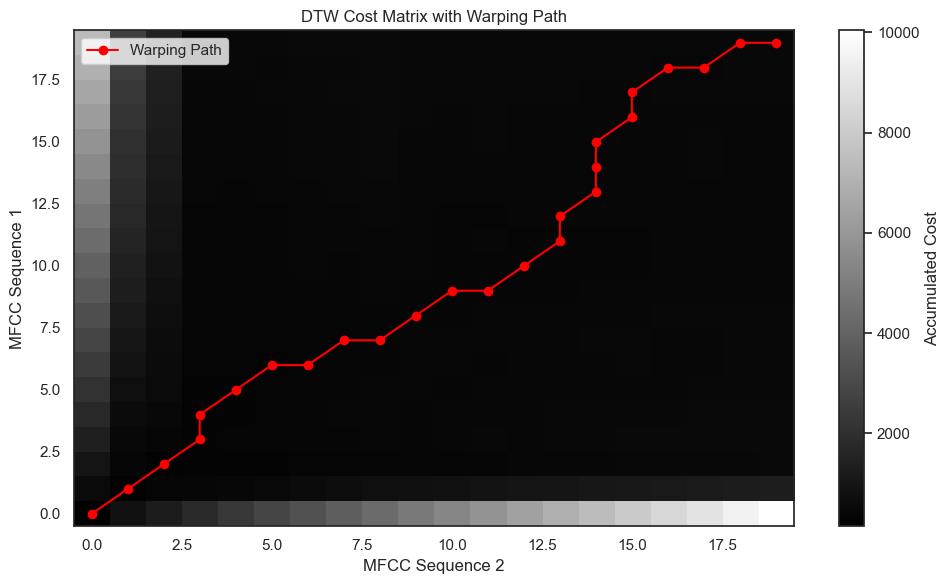

In [171]:
D, wp_s = compare_mfcc_dtw(mfcc1, mfcc2)
cost_matrix_wrapping_path(D, wp_s)

In [172]:
# Dynamic Time Warping Between Same Word
target_word = "one"
word_samples = processed_df[processed_df['WORD'] == target_word]

def create_distance_matrix(samples):
    n = len(samples)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):  # Only compute upper triangle
            if i == j:
                matrix[i][j] = 0  # Distance to self is 0
            else:
                mfcc1 = samples.iloc[i]['MFCC']
                mfcc2 = samples.iloc[j]['MFCC']
                D, _ = compare_mfcc_dtw(mfcc1, mfcc2)
                matrix[i][j] = D[-1, -1]
                matrix[j][i] = matrix[i][j]  # Symmetric

    return matrix

In [173]:
# Visualise Distance Matrix
def plot_distance_matrix(word, max_samples=10):
    samples = processed_df[processed_df['WORD'] == word].head(max_samples)
    if len(samples) < 2:
        print(f"Not enough samples for {word}")
        return

    dist_matrix = create_distance_matrix(samples)

    plt.figure(figsize=(8, 6))
    sns.heatmap(dist_matrix, annot=True, fmt=".1f", cmap="YlOrRd",
                xticklabels=range(len(samples)),
                yticklabels=range(len(samples)))
    plt.title(f"DTW Distance Matrix for '{word.capitalize()}'")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.show()

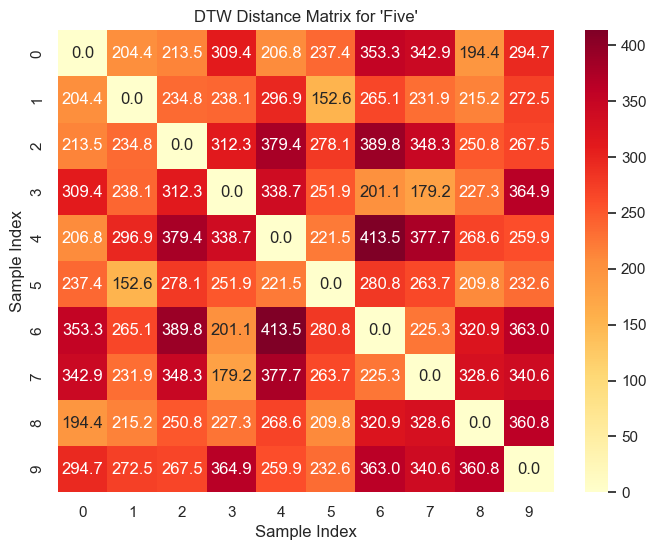

In [174]:
plot_distance_matrix("five")

In [175]:
# Comparing MFCC Across Different Words
def compare_words_mfcc(word1, word2):
    samples1 = processed_df[processed_df['WORD'] == word1].iloc[0]['MFCC']
    samples2 = processed_df[processed_df['WORD'] == word2].iloc[0]['MFCC']

    # Reshape to (20, n_frames) if needed
    if samples1.ndim == 1:
        samples1 = samples1.reshape(-1, 1)
    if samples2.ndim == 1:
        samples2 = samples2.reshape(-1, 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    sns.heatmap(samples1, ax=ax1, cmap='viridis', cbar=False)
    ax1.set_title(f"MFCC for '{word1}'")
    ax1.set_ylabel("MFCC Coefficients")

    sns.heatmap(samples2, ax=ax2, cmap='viridis')
    ax2.set_title(f"MFCC for '{word2}'")

    plt.suptitle("MFCC Comparison Between Words")
    plt.show()

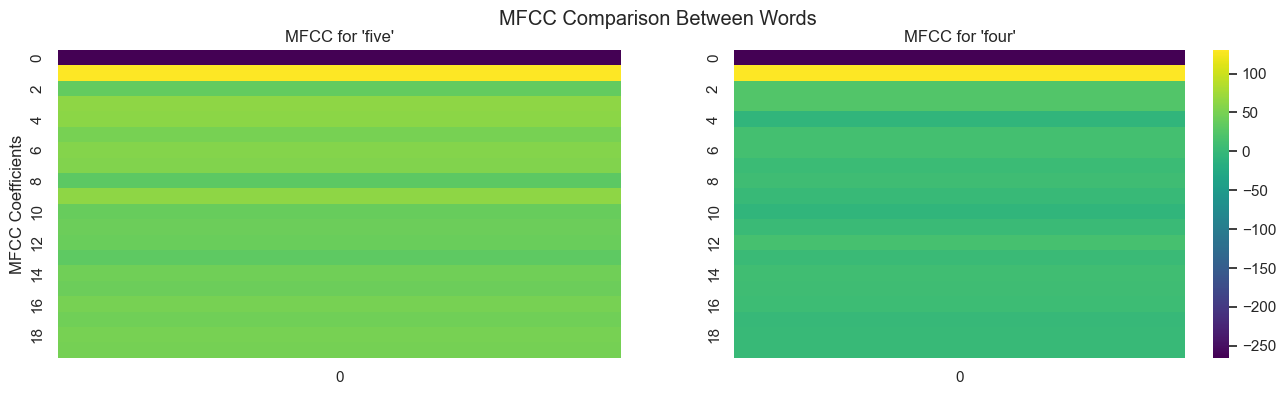

In [176]:
compare_words_mfcc("five", "four")  # Change to words in your dataset

In [178]:
### UMAP Projection Visualisation
# Standardise Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [186]:
import umap.umap_ as umap

# Create UMAP projection
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
projection = reducer.fit_transform(X_scaled)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [187]:
viz_df = pd.DataFrame({
    'x': projection[:, 0],
    'y': projection[:, 1],
    'word': y
})

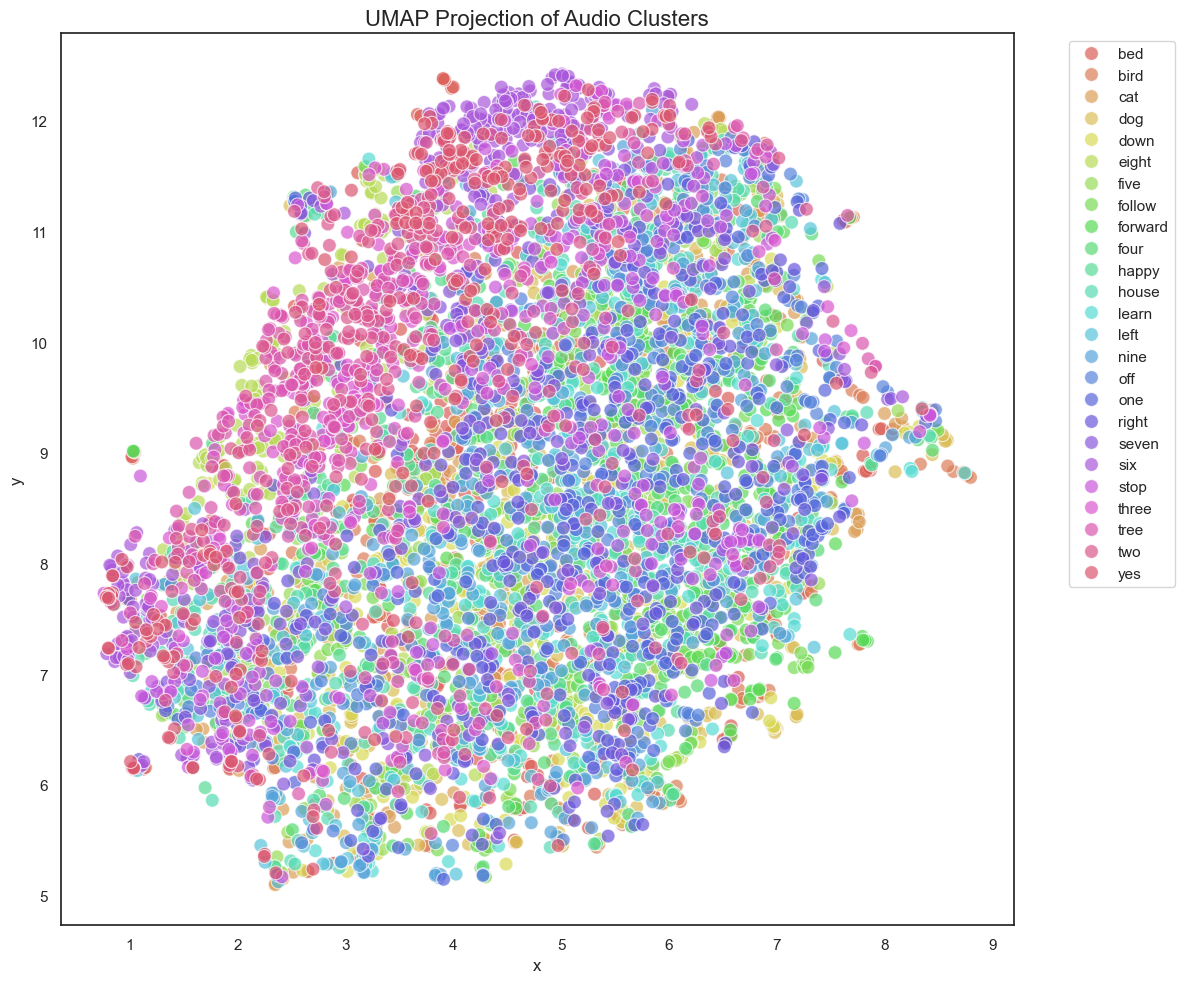

In [188]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="x",
    y="y",
    hue="word",
    data=viz_df,
    palette=sns.color_palette("hls", n_colors=len(viz_df['word'].unique())),
    s=100,
    alpha=0.7
)
plt.title("UMAP Projection of Audio Clusters", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()